In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
import numpy as np
import shap
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
optuna.logging.disable_default_handler()



In [3]:
def encode_and_bind(original_dataframe, feature_to_encode):
    new_df = pd.get_dummies(original_dataframe, columns= feature_to_encode,drop_first=True,dummy_na = True)
    #new_df.drop('id', inplace=True, axis=1)
    return new_df


def fill_all_nan_to_minus_one(dataframe):   
    return dataframe.fillna(-1)



In [4]:
df = pd.read_csv("Data/patient_features_early_stage.csv",sep=",")
Y = df['relapse?'].values
df.drop(['id','relapse?'], inplace=True, axis=1)
print ("Total number of relapsed patient in the data:",np.count_nonzero(Y))
print ("Total number of survived patient in the data:",len(Y)-np.count_nonzero(Y))
print ("Total number of patient:",len(Y))


Total number of relapsed patient in the data: 491
Total number of survived patient in the data: 857
Total number of patient: 1348


In [5]:
aneuploidy = np.loadtxt("Predicted_Aneuploidy_knn.txt",dtype = np.float32)

In [6]:
#sorted(df.columns)

In [7]:
all_features = list(df.columns)
general_features = ["age",'family_lung_cancer','family_other_cancer','gender','lived_with_smokers_20_years',
                    'lives_with_smokers','nb_cig_packs_year','nb_cigs_day','previous_cancer_type','race','smoker']
surgery_features = [surg for surg in df.columns if surg.startswith('surgery')==True]
radio_therapy_features = [radio for radio in df.columns if radio.startswith('radio')==True]
chemo_therapy_features = [chemo for chemo in df.columns if chemo.startswith('chemo')==True]
treatment_features = surgery_features + radio_therapy_features + chemo_therapy_features
diagnosis_features = list(set(all_features) - set(general_features + treatment_features))

#all_features
#relapse prediction with first sugery and first chemotherapy feature#
#df = df[general_features + diagnosis_features + treatment_features]
#relapse prediction with diagnosis feature#
#df = df[general_features]
#df = df[diagnosis_features]
#df = df[general_features + diagnosis_features]
#relapse prediction with surgery feature#
#df = df[general_features + diagnosis_features + surgery_features]
#relapse prediction with radiotherapy feature#
#df = df[general_features + diagnosis_features + surgery_features]
#df = df[chemo_therapy_features]
#relapse prediction with first sugery and first chemotherapy feature#
#df = df[general_features + diagnosis_features + radio_therapy_features]
#df = df[general_features + diagnosis_features + radio_therapy_features + chemo_therapy_features + surgery_features]
#df = df.drop(df.columns.values, axis=1)
#df = df[treatment_features]
df = df[general_features + diagnosis_features + treatment_features]
df["aneuploidy_imputed"]= aneuploidy
cat_columns = list(df.select_dtypes(['object']).columns)
bool_columns = list(df.select_dtypes(['bool']).columns)
feature_to_encode = cat_columns + bool_columns

new_df = encode_and_bind(df, feature_to_encode)
new_df = fill_all_nan_to_minus_one(new_df)
X = new_df.values

In [8]:
#diagnosis_features

In [9]:
X.shape

(1348, 216)

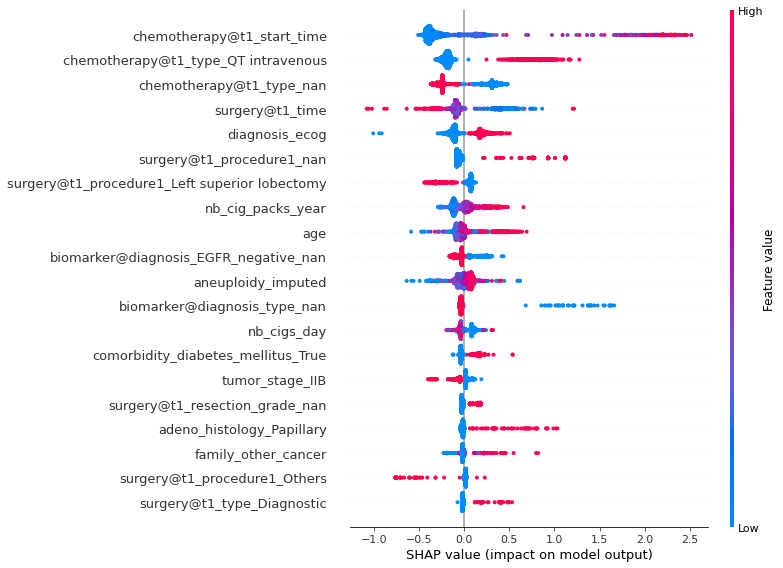

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
#model = RandomForestClassifier()
#model = LogisticRegression()
model.fit(X, Y)
#explainer = shap.Explainer(model.predict, X)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

f = plt.figure()
shap.summary_plot(shap_values, X, feature_names = new_df.columns.values)
f.savefig("summary_plot1.eps", bbox_inches='tight')
f.savefig("summary_plot1.png", bbox_inches='tight')

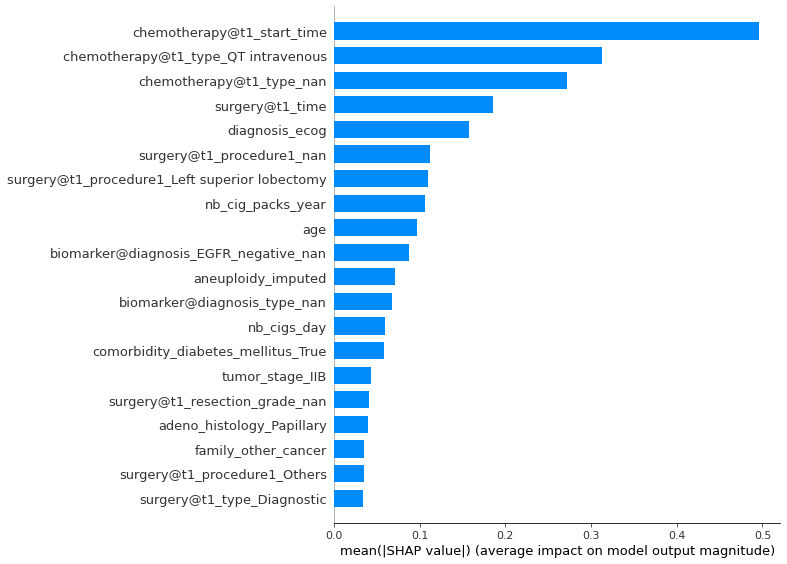

In [11]:
f = plt.figure()
shap.summary_plot(shap_values, features=X, feature_names=new_df.columns.values, plot_type='bar')
f.savefig("summary_plot2.eps", bbox_inches='tight')
f.savefig("summary_plot2.png", bbox_inches='tight')

In [12]:
#shap_values = explainer.shap_values(X)
#shap.dependence_plot("aneuploidy_imputed", shap_values,X, feature_names =new_df.columns.values)

In [13]:
#shap.plots.bar(shap_values.abs.mean(0))

In [14]:
def calculate_metrics(y_predicted, y_predicted_prob,y_true):
    accuracy = accuracy_score(y_true, y_predicted)
    precision = precision_score(y_true, y_predicted)
    recall = recall_score(y_true, y_predicted)
    f_score =  f1_score(y_true, y_predicted)
    roc_score = roc_auc_score(y_true,y_predicted_prob)
    prec, rec, _ = precision_recall_curve(y_true,y_predicted_prob)
    auc_score = auc(rec, prec)
    return accuracy, precision,recall,f_score,roc_score,auc_score
    

    


In [15]:
def random_forest_objective(trial,X_train, y_train):
    
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    classifier_obj = RandomForestClassifier(
                     max_depth=max_depth, n_estimators=n_estimators,random_state=123
        )

    score = cross_val_score(classifier_obj,X_train,y_train,
                            scoring ="average_precision",n_jobs=-1, cv=3)
    f1_scr = score.mean()
    
    return f1_scr


def random_forest(params,X_test, y_test):
    #print (params)
    model = RandomForestClassifier(**params,n_jobs=-1, random_state=123)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    #predicted_prob = np.argmax(predicted_prob,axis=1)
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score


def svm_objective(trial,X_train, y_train):
    
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    classifier_obj = LinearSVC(C=C)

    score = cross_val_score(classifier_obj,X_train,y_train,
                            scoring ="average_precision",n_jobs=-1, cv=3)
    f1_scr = score.mean()
    
    return f1_scr


def svm_class(params,X_test, y_test):
    #print (params)
    model = LinearSVC(**params, random_state=123)
    clf = CalibratedClassifierCV(model) 
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    #predicted_prob = np.argmax(predicted_prob,axis=1)
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score


def logistic_regression_objective(trial,X_train, y_train):
    C = trial.suggest_float("C", 1e-10, 1e10, log=True)
    classifier_obj = LogisticRegression(C=C)
    
    score = cross_val_score(classifier_obj,X_train,y_train,
                            scoring ="average_precision",n_jobs=-1, cv=3)
    f1_scr = score.mean()
    
    return f1_scr


def logistic_regression(params,X_test, y_test):
    #print (params)
    model = LogisticRegression(**params,n_jobs=-1, random_state=123)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    #predicted_prob = np.argmax(predicted_prob,axis=1)
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score


def gbm_objective(trial,X_train, y_train):
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10, log=True)
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 20, log=True)
    
    classifier_obj = GradientBoostingClassifier(
                     max_depth= max_depth, min_samples_leaf= min_samples_leaf, max_features= max_features,
                     max_leaf_nodes = max_leaf_nodes, random_state=123
        )
    
    score = cross_val_score(classifier_obj,X_train,y_train,
                            scoring ="f1",n_jobs=-1, cv=3)
    f1_scr = score.mean()
    
    return f1_scr


def gbm(params,X_test, y_test):
    #print (params)
    model = GradientBoostingClassifier(**params,random_state=123)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    #predicted_prob = np.argmax(predicted_prob,axis=1)
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score
    

    
    
    
def neural_nets_objective(trial,X_train, y_train):
    hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 2, 10)
    activation = trial.suggest_categorical("activation", ["relu"])
    solver = trial.suggest_categorical("solver", ["adam"])
    
    
    classifier_obj = MLPClassifier(
                     hidden_layer_sizes= hidden_layer_sizes, activation= activation, solver = solver,random_state=123
        )
    
    score = cross_val_score(classifier_obj,X_train,y_train,
                            scoring ="f1",n_jobs=-1, cv=3)
    f1_scr = score.mean()
    
    return f1_scr


def neural_nets(params,X_test, y_test):
    
    model = MLPClassifier(**params,random_state=123)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    predicted_prob = predicted_prob[:,1]
    #predicted_prob = np.argmax(predicted_prob,axis=1)
    accuracy, precision,recall,f_score,roc_score,auc_score = calculate_metrics(predicted, predicted_prob,y_test)
    return accuracy, precision,recall,f_score,roc_score,auc_score
    
    
    



In [16]:

if __name__ == "__main__":
    FOLDS = 5
    #     skf = KFold(n_splits=FOLDS)
    kf = KFold(n_splits=FOLDS,random_state=7,shuffle=True)
    models = ["svc","logistic_regression","random_forest","gbm","neural_networks"]
    eval_metrics = {}
    for mod in models:
        cnt = 0
        acc = np.zeros(FOLDS)
        prec = np.zeros(FOLDS)
        rec = np.zeros(FOLDS)
        f_score = np.zeros(FOLDS)
        roc_score = np.zeros(FOLDS)
        auc_pr = np.zeros(FOLDS)
#         for train_index, test_index in skf.split(X,Y):
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            sampler = TPESampler(seed=10)
            study = optuna.create_study(direction="maximize",sampler=sampler)
            if mod =="logistic_regression":
                study.optimize(lambda trial: logistic_regression_objective(trial, X_train, y_train), n_trials=50)
                logistic_regression_params = study.best_params
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = logistic_regression(logistic_regression_params,X_test, y_test)
                
            elif mod =="random_forest":
                study.optimize(lambda trial: random_forest_objective(trial, X_train, y_train), n_trials=50)
                randomforest_params = study.best_params
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = random_forest(randomforest_params,X_test, y_test)
                
            
            elif mod =="svc":
                study.optimize(lambda trial: svm_objective(trial, X_train, y_train), n_trials=50)
                svm_params = study.best_params
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = svm_class(svm_params,X_test, y_test)
                
            
            elif mod =="neural_networks":
                study.optimize(lambda trial: neural_nets_objective(trial, X_train, y_train), n_trials=50)
                neural_nets_params = study.best_params
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = neural_nets(neural_nets_params,X_test, y_test)
            
            else:
                study.optimize(lambda trial: gbm_objective(trial, X_train, y_train), n_trials=50)
                gbm_params = study.best_params
                acc[cnt],prec[cnt],rec[cnt],f_score[cnt],roc_score[cnt],auc_pr[cnt] = gbm(gbm_params,X_test, y_test)
    
            cnt+=1
        
        print ("Results for:",mod)
        print ("Accuracy:",np.around(acc.mean(),decimals=2),u"\u00B1",np.around(acc.std(),decimals=2))
        print ("Precision:",np.around(prec.mean(),decimals=2),u"\u00B1",np.around(prec.std(),decimals=2))
        print ("Recall:",np.around(rec.mean(),decimals=2),u"\u00B1",np.around(rec.std(),decimals=2))
        print ("F1_score:", np.around(f_score.mean(),decimals=2),u"\u00B1",np.around(f_score.std(),decimals=2))
        print ("ROC_score:", np.around(roc_score.mean(),decimals=2),u"\u00B1",np.around(roc_score.std(),decimals=2))
        print ("PR_score",np.around(auc_pr.mean(),decimals=2),u"\u00B1",np.around(auc_pr.std(),decimals=2))
        eval_metrics[mod]= [acc.mean(),prec.mean(),rec.mean(),f_score.mean(),roc_score.mean(),auc_pr.mean()]
        

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py3

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py3

Results for: svc
Accuracy: 0.75 ± 0.01
Precision: 0.77 ± 0.04
Recall: 0.44 ± 0.07
F1_score: 0.56 ± 0.05
ROC_score: 0.79 ± 0.02
PR_score 0.72 ± 0.05


/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py3

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py3

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py3

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py3

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

Results for: logistic_regression
Accuracy: 0.75 ± 0.02
Precision: 0.73 ± 0.02
Recall: 0.51 ± 0.05
F1_score: 0.6 ± 0.04
ROC_score: 0.78 ± 0.01
PR_score 0.71 ± 0.04
Results for: random_forest
Accuracy: 0.77 ± 0.03
Precision: 0.79 ± 0.05
Recall: 0.48 ± 0.08
F1_score: 0.59 ± 0.08
ROC_score: 0.8 ± 0.03
PR_score 0.73 ± 0.06
Results for: gbm
Accuracy: 0.76 ± 0.02
Precision: 0.72 ± 0.03
Recall: 0.53 ± 0.06
F1_score: 0.61 ± 0.04
ROC_score: 0.8 ± 0.01
PR_score 0.74 ± 0.05


/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the o

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

Results for: neural_networks
Accuracy: 0.74 ± 0.03
Precision: 0.68 ± 0.03
Recall: 0.53 ± 0.06
F1_score: 0.59 ± 0.05
ROC_score: 0.77 ± 0.02
PR_score 0.7 ± 0.04


In [17]:
# eval_metrics

In [20]:
# eval_metrics
# df = pd.DataFrame(data=eval_metrics)
# df.index = ['Accuracy', 'Precision', 'Recall','F1','ROC','AUC_PR']
# df